In [ ]:


# download dataet
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar


--2023-04-23 16:39:00--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar.2’

UCF50.rar.2         100%[===================>]   3.01G  25.8MB/s    in 2m 1s   

2023-04-23 16:41:02 (25.5 MB/s) - ‘UCF50.rar.2’ saved [3233554570/3233554570]



In [ ]:
!unrar x /content/UCF50.rar.2

In [ ]:
# install the required libraries
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
# import libraries
import os
import cv2
import random
import numpy as np
import pafy
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Step 1: Visualize the Data with its Labels
- 50 action
- size (240, 320, 3)

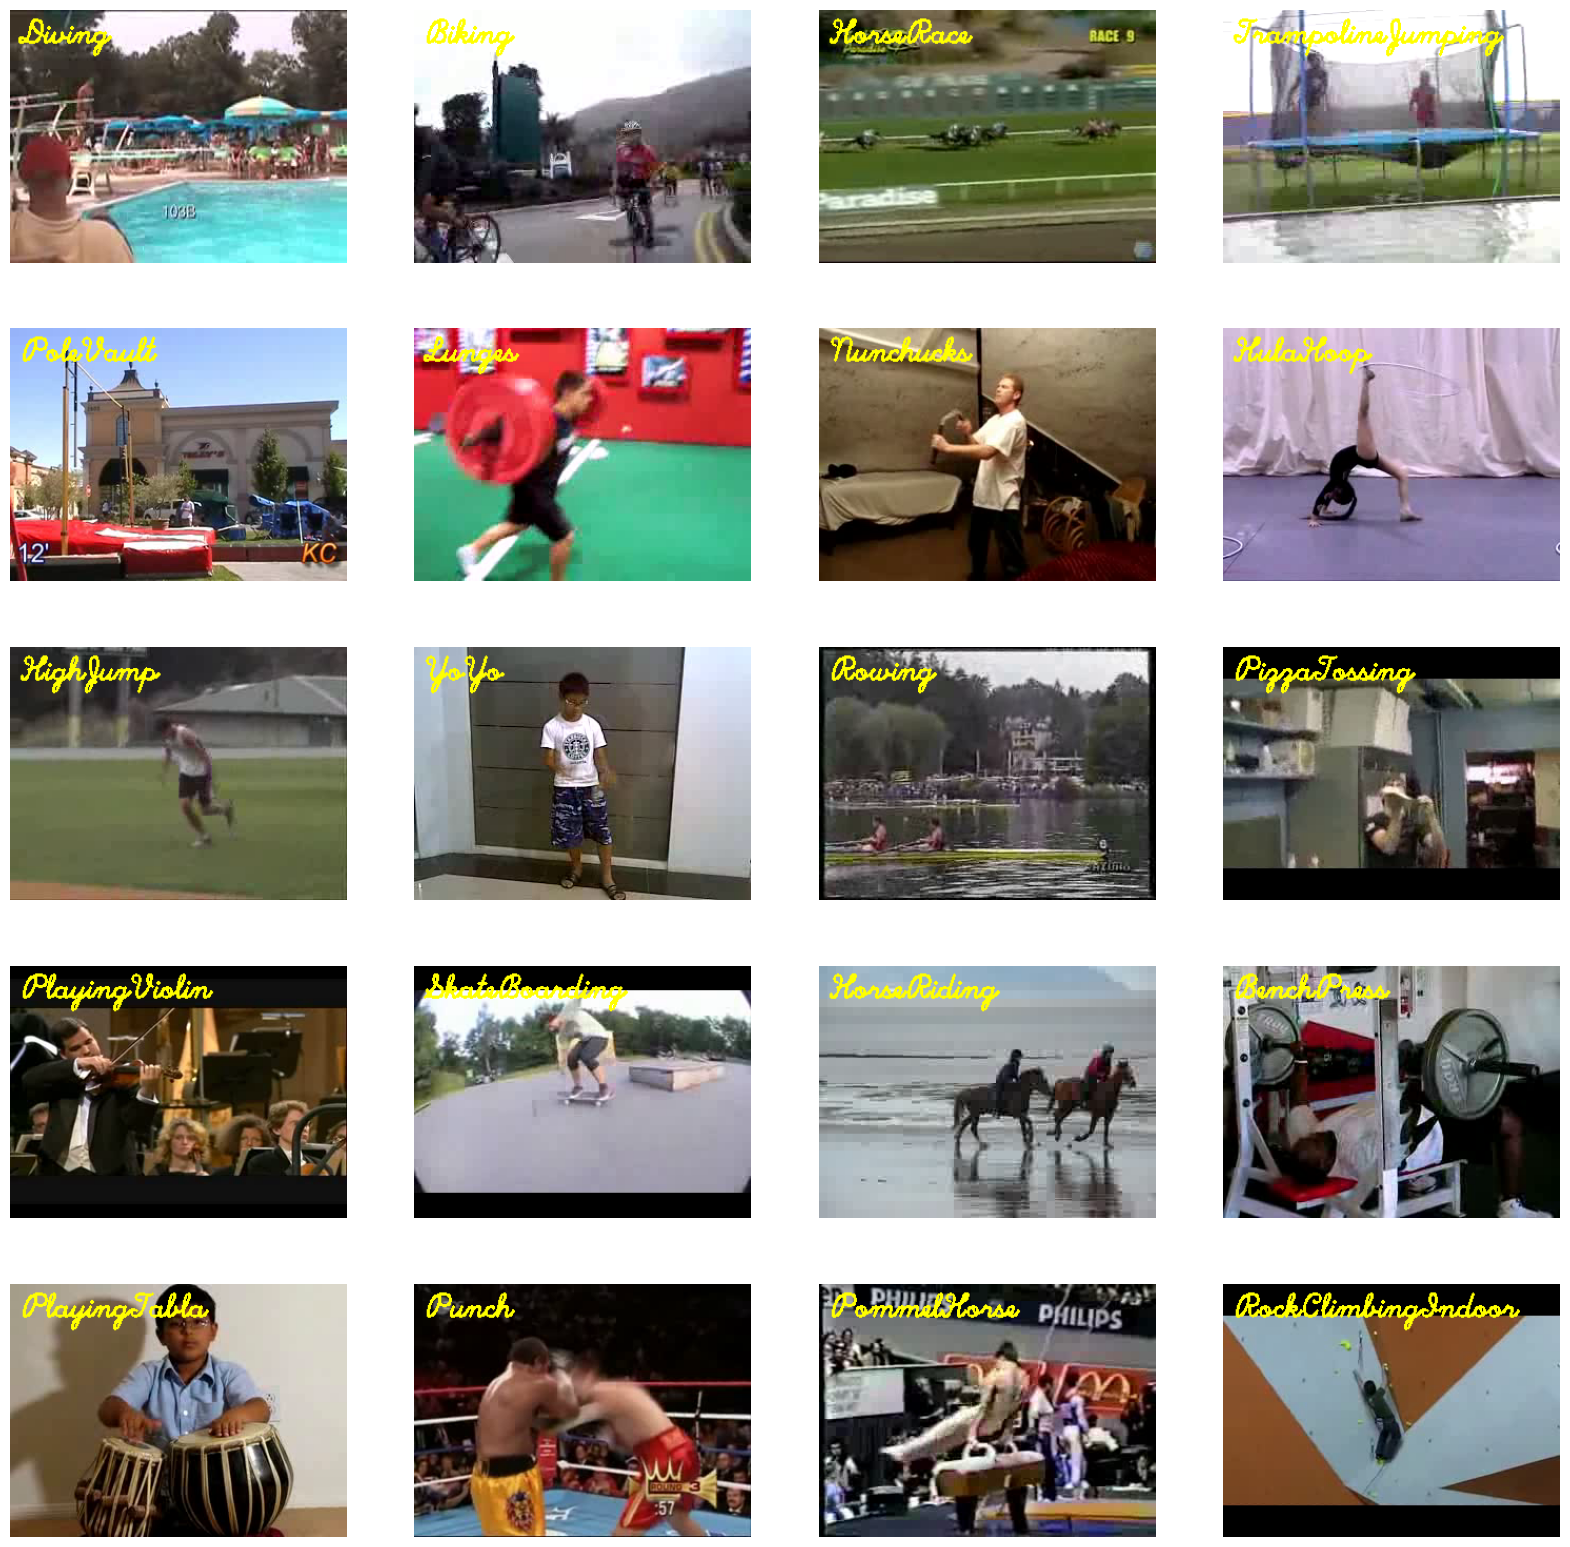

In [ ]:
# tao 1 matplotlib voi size set up
plt.figure(figsize =  (20, 20))

# get names of all classes
all_classes_names = os.listdir('/content/UCF50')

# tao danh sach 20 gia tri. cac gia tri tu 0 - 50
# 50 classes
random_range = random.sample(range(len(all_classes_names)), 20)

# lap lai cac gia tri duoc tao
for counter, random_index in enumerate(random_range, 1):
  
  # truy xuat ten class 
  selected_class_Name = all_classes_names[random_index]

  # truy xuat cac tep trong class 
  video_files_list = os.listdir(f'/content/UCF50/{selected_class_Name}')

  # chon ngau nhien 1 tep video
  selected_video_file_name = random.choice(video_files_list)

  # doc file tu file video
  video_reader = cv2.VideoCapture(f'/content/UCF50/{selected_class_Name}/{selected_video_file_name}')

  # doc frame dau tu doc video
  _, bgr_frame = video_reader.read()

  # giai phons Videocapture
  video_reader.release()

  # chuyen doi frame tu BGR sang RGB
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # viet ten class len anh
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1,
              (255, 255, 0), 2)
  
  # show ra man hinh
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


### Step 2: Preprocess the Dataset
- Doc cac tep Video
- thay doi kich thuoc
- chuan moi pixel nam tu [0:1]

In [ ]:
# set up kich thuoc cho huan luyen
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# frame of a video
SEQUENCE_LENGTH = 20

# dia chi luu 50 class
DATASET_DIR = "/content/UCF50"

# train 4 class de nhanh hon
CLASSES_LIST = ['TaiChi', 'Punch', 'Drumming', 'Swing']

## create a function de trich xuat, thay doi kich thuoc va chuan hoa khung hinh


In [ ]:
def frames_extraction(video_path):
  '''
  Trich xuat cac khung hinh can thiet
  dau vao: ten duong dan filvideo
  dau ra: danh sach khung hinh da thay doi kich thuoc va chuan hoa
  '''

  # khai bao noi luu tru
  frames_list = []

  # doc video
  video_reader = cv2.VideoCapture(video_path)

  # get total number frame of frame in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # tinh toan khoang thoi gian sau moi frame them vao list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  
  # lap qua cac video frame
  for frame_counter in range(SEQUENCE_LENGTH):

    # dat thoi gian khung hinh hien tai cua video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # reading frame of video
    success, frame = video_reader.read()

    # neu khong thanh cong thi break
    if not success:
      break

    # Resize of the frame
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    # set up moi pixel ve khoang [0:1]
    normalized_frame = resized_frame / 255

    # append frame into the list
    frames_list.append(normalized_frame)
  
  # release the videocapture
  video_reader.release()

  # tra ve list frame
  return frames_list



## Create a function for dataset creation

In [ ]:
def create_dataset():
  '''
  ham nay se trich xuat lop du lieu va tao bo du lieu can thiet
  return:
    features: cac dac trung cua frame of video
    labels: classes
    video_files_paths: danh sach duong dan
  '''

  # tao cac list
  features = []
  labels = []
  video_files_paths = []

  # lap qua cac class trong class list
  for class_index, class_name in enumerate(CLASSES_LIST):

    # hien ra man hinh the name of class
    print(f'Extracting Data of Class:  {class_name}')

    # lay cac tep video trong thu muc class
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    # lap qua cac file trong class
    for file_name in files_list:

      # get the complete video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      # trich xuat cac frame tu duong dan file video
      frames = frames_extraction(video_file_path)

      # kiem tra xem frames co so khung bang SEQUENCE_LENGTH 
      # be hon thi loai bo
      if len(frames) == SEQUENCE_LENGTH:

        # append the data to list
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # convert the list to numpy arrays
  features = np.asarray(features)
  labels = np.asarray(labels)

  # return the frames, class index, video file path
  return features, labels, video_files_paths



In [ ]:
# create the dataset

features, labels, video_files_paths = create_dataset()

Extracting Data of Class:  TaiChi
Extracting Data of Class:  Punch
Extracting Data of Class:  Drumming
Extracting Data of Class:  Swing


In [ ]:
# convert labels to array
one_hot_encoded_labels = to_categorical(labels)

### Step 3: Split data into train and test


In [ ]:
features_train, features_test , labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.25, 
                                                                             shuffle=True, random_state=seed_constant)

### Step 4: Implement the ConvLSTM 

## Step 4.1: Construct the Model
- use keras.ConvLSTM2D
- MaxPool3D
- Dropout tranh overfitting

In [ ]:
def create_convlstm_model():
  '''
  will contruct the convlstm model
  return: model
  '''

  # use model Sequential
  model = Sequential()

  # Define the model

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation='tanh',
                       data_format="channels_last", 
                       recurrent_dropout=0.2, return_sequences=True,
                       input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size =  (3, 3), activation='tanh',
                       data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size =  (3, 3), activation='tanh',
                       data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 32, kernel_size =  (3, 3), activation='tanh',
                       data_format="channels_last", recurrent_dropout=0.2, return_sequences=True))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
 
  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation="softmax"))

  # summary
  model.summary()

  return model




In [ ]:
# construct model
convlstm_model = create_convlstm_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

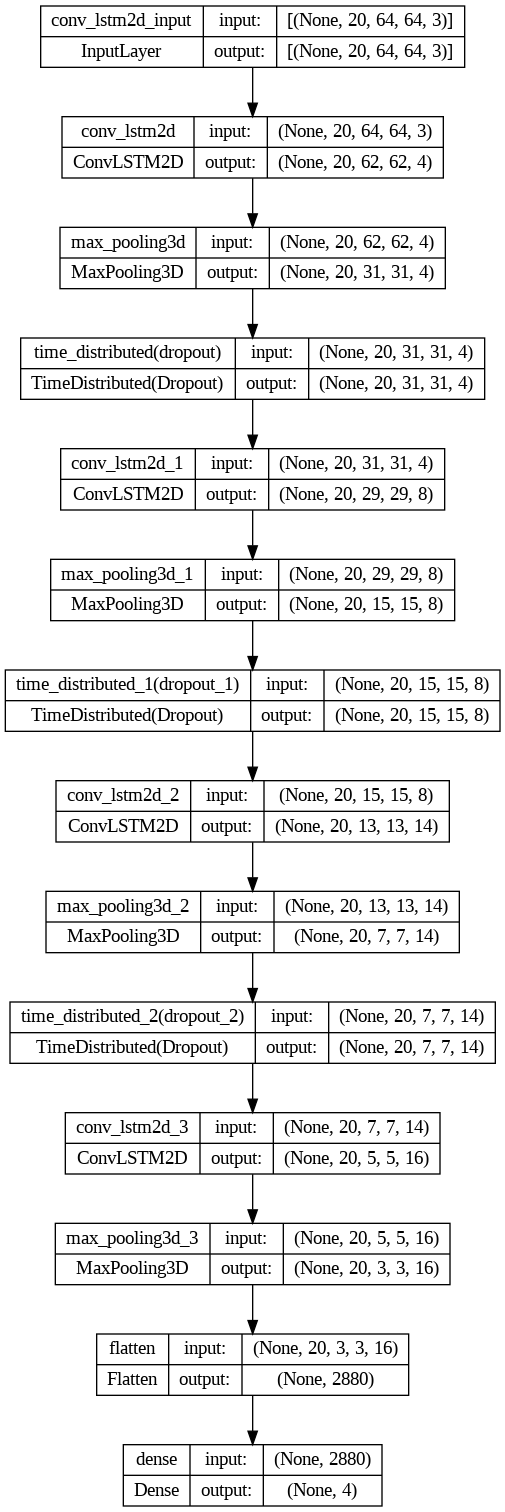

In [ ]:
# show model construct
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

## Step 4.2: Compile and Train 
- su dung Callback de ngan overfiiting qua muc

In [ ]:
# create callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10,
                                        mode = 'min', restore_best_weights=True)

# compile and cai dat ham loss, optimizer, metrics
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs = 5, batch_size=4,
                                                     shuffle=True, validation_split=0.2, 
                                                     callbacks=[early_stopping_callback])



Epoch 1/5
84/84 [==============================] - 61s 580ms/step - loss: 0.1045 - accuracy: 0.9581 - val_loss: 0.2953 - val_accuracy: 0.8810
Epoch 2/5
84/84 [==============================] - 50s 587ms/step - loss: 0.0656 - accuracy: 0.9790 - val_loss: 0.3084 - val_accuracy: 0.9167
Epoch 3/5
84/84 [==============================] - 47s 559ms/step - loss: 0.0164 - accuracy: 0.9940 - val_loss: 0.3035 - val_accuracy: 0.9167
Epoch 4/5
84/84 [==============================] - 47s 562ms/step - loss: 0.0130 - accuracy: 0.9940 - val_loss: 0.2716 - val_accuracy: 0.9048
Epoch 5/5
84/84 [==============================] - 70s 837ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2948 - val_accuracy: 0.9167


## Evaluating the model


In [ ]:
evaluation_convlstm_model = convlstm_model.evaluate(features_test, labels_test)

5/5 [==============================] - 2s 107ms/step - loss: 0.3106 - accuracy: 0.9143


In [ ]:
import os
os.chdir('/content/drive/MyDrive')
convlstm_model.save('convlstm_model.h5')

## Save model

In [ ]:
model_evaluation_loss, model_evaluation_accuracy = evaluation_convlstm_model

model_file_name = f'ConvLSTM_activity_human_Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

### Step 5: plot loss and accutacy

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
  model_training_history: loss and accuracy
  metric_name_1: ten chi so 1
  metric_name_2: ten chi so 2
  plot_name: name of title
  '''

  # get metric
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # so luong lam truc x
  epochs = range(len(metric_value_1))

  # plot and graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # add title
  plt.title(str(plot_name))

  # add legend
  plt.legend()


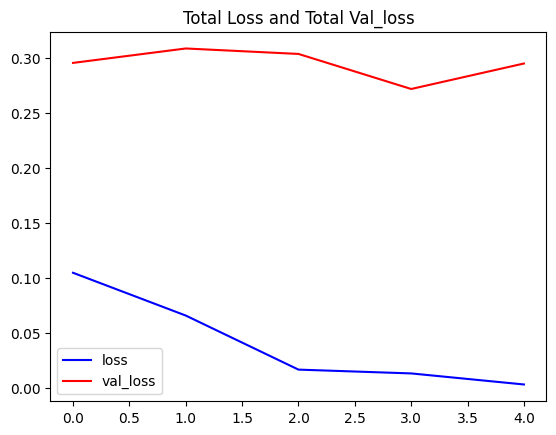

In [ ]:
# visualize the train and validation loss metrics
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss and Total Val_loss')

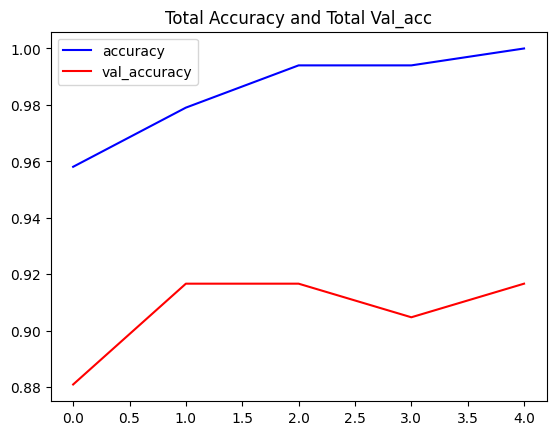

In [ ]:
# Visualize the training and validation accuracy metric
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy and Total Val_acc')